# Superstore Sales Workflow Tutorial

This notebook walks through cleaning the Superstore dataset, designing a relational structure, creating an SQLite database, and running example SQL queries and visualizations.

In [206]:
import pandas as pd
import os
import sqlite3
from sqlite3 import connect
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

## 1️) Load and Inspect the Dataset

In [207]:
# reading error codes + research is how you can learn if there is different encoding, as seen below
df = pd.read_csv('../data/Superstore.csv', encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87
3,4,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
4,5,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


### Double check some datatypes, and for nulls and duplicates:

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [209]:
df.duplicated().sum()

np.int64(0)

In [210]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

This data is incredibly clean - we can see there are no null values and no duplicates. However, there are some dates that could be saved in a better format.

## 2) Data Cleaning

In [211]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

In [212]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [213]:
df.Segment.unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [214]:
df.rename(columns={"Segment":"customer_category"}, inplace=True)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,customer_category,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


With real data, it is very likely more cleaning and wrangling would be required. 

## 3) Build Relational Tables

In [215]:
conn = sqlite3.connect('../data/superstore.db')

customers_df = df[['Customer ID','Customer Name','customer_category','City','State','Region', 'Postal Code']].drop_duplicates().rename(columns={
    'Customer ID':'customer_id',
    'Customer Name':'customer_name',
    'City':'city',
    'State':'state',
    'Region':'region',
    'Postal Code':'postal_code'
})

products_df = df[['Product ID','Category','Sub-Category','Product Name']].drop_duplicates().rename(columns={
    'Product ID':'product_id',
    'Category':'category',
    'Sub-Category':'subcategory',
    'Product Name':'product_name'
})

orders_df = df[['Order ID','Order Date','Ship Date','Ship Mode','Customer ID']].drop_duplicates().rename(columns={
    'Order ID':'order_id',
    'Order Date':'order_date',
    'Ship Date':'ship_date',
    'Ship Mode':'ship_mode',
    'Customer ID':'customer_id'
})

order_details_df = df[['Order ID','Product ID','Sales','Quantity','Discount','Profit']].rename(columns={
    'Order ID':'order_id',
    'Product ID':'product_id'
})

customers_df.to_sql('customers', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
order_details_df.to_sql('order_details', conn, index=False, if_exists='replace')
conn.commit()

## 4) Make Some Queries!

### Which customer segments bring in the most revenue and profit?

In [216]:
query1 = """ SELECT 
    c.customer_category,
    ROUND(SUM(od.sales), 2) AS total_sales,
    ROUND(SUM(od.profit), 2) AS total_profit
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_category
ORDER BY total_sales DESC;
"""
result1 = pd.read_sql(query1, conn)
result1

,customer_category,total_sales,total_profit
0,Consumer,"8,380,282.43","973,085.86"
1,Corporate,"5,044,899.83","660,287.69"
2,Home Office,"2,964,459.36","434,344.01"


### What are the top 10 customers by total sales?

In [217]:
query2 = """
SELECT customers.customer_name, SUM(order_details.profit) AS total_sales
FROM customers
JOIN orders ON customers.customer_id = orders.customer_id
JOIN order_details ON orders.order_id = order_details.order_id
WHERE customers.customer_id > 0
GROUP BY customers.customer_id, customers.customer_name
ORDER BY total_sales DESC
LIMIT 10;
"""
result2 = pd.read_sql(query2, conn)
result2

,customer_name,total_sales
0,Sanjit Chand,"51,816.71"
1,Adrian Barton,"49,003.25"
2,Tamara Chand,"44,906.62"
3,Raymond Buch,"41,856.58"
4,Hunter Lopez,"33,734.58"
5,Keith Dawkins,"30,386.25"
6,Sanjit Engle,"29,157.45"
7,Pete Kriz,"24,459.21"
8,Harry Marie,"24,379.84"
9,Brian Moss,"24,192.06"


### Which product categories and subcategories are the most profitable overall?

In [218]:
query3 = """ 
SELECT products.category, products.subcategory, SUM(order_details.profit) AS total_profit
FROM order_details
JOIN products 
ON order_details.product_id = products.product_id
GROUP BY products.category, products.subcategory
ORDER BY total_profit DESC;
"""
result3 = pd.read_sql(query3, conn)
result3

,category,subcategory,total_profit
0,Technology,Copiers,"55,617.82"
1,Technology,Accessories,"48,359.05"
2,Technology,Phones,"46,936.19"
3,Office Supplies,Paper,"36,994.53"
4,Office Supplies,Binders,"30,373.20"
5,Furniture,Chairs,"26,707.65"
6,Office Supplies,Storage,"21,408.70"
7,Office Supplies,Appliances,"18,514.49"
8,Furniture,Furnishings,"14,569.59"
9,Office Supplies,Envelopes,"6,964.18"


### What is the average discount given per category?

In [219]:
query4 = """ 
SELECT products.category, AVG(order_details.discount) AS average_discount
FROM order_details
JOIN products 
ON order_details.product_id = products.product_id
GROUP BY products.category
ORDER BY average_discount DESC;
"""

result4 = pd.read_sql(query4, conn)
result4

,category,average_discount
0,Furniture,0.17
1,Office Supplies,0.16
2,Technology,0.13


### Which states or regions contribute the most to total sales?

In [220]:
query5 = """
SELECT customers.state, customers.region, SUM(order_details.sales) AS total_sales
FROM order_details
JOIN orders
ON order_details.order_id = orders.order_id
JOIN customers
ON orders.customer_id = customers.customer_id
GROUP BY customers.state
ORDER BY total_sales DESC
LIMIT 10;
"""
result5 = pd.read_sql(query5, conn)
pd.options.display.float_format = '{:,.2f}'.format
result5

,state,region,total_sales
0,California,West,"3,314,837.69"
1,New York,East,"1,859,365.37"
2,Texas,Central,"1,547,925.76"
3,Pennsylvania,East,"886,105.68"
4,Washington,West,"862,298.69"
5,Illinois,Central,"843,352.76"
6,Ohio,East,"707,747.69"
7,Florida,South,"635,637.78"
8,North Carolina,South,"437,938.43"
9,Michigan,Central,"432,428.02"


### How many orders were shipped late (where Ship Date > Order Date + 3 days)?

In [221]:
query6 = """
SELECT COUNT(*) AS late_orders
FROM orders
WHERE ship_date > DATE(order_date, '+3 day');
"""
result6 = pd.read_sql(query6, conn)
result6

,late_orders
0,3902


### Which month or year had the highest total sales?

In [222]:
query7 = """
SELECT SUBSTR(order_date, 1, 4) AS year, SUBSTR(order_date, 6, 2) AS month, SUM(order_details.sales) AS total_sales
FROM order_details
JOIN orders 
ON order_details.order_id = orders.order_id
GROUP BY year, month
ORDER BY total_sales DESC
LIMIT 12;
"""
result7 = pd.read_sql(query7, conn)
result7

,year,month,total_sales
0,2014,11,"112,326.47"
1,2013,12,"97,237.42"
2,2014,09,"90,488.72"
3,2014,12,"90,474.60"
4,2013,11,"82,192.32"
5,2011,09,"81,777.35"
6,2011,11,"78,628.72"
7,2014,10,"77,793.76"
8,2012,11,"75,972.56"
9,2012,12,"74,919.52"


### What are the most frequently ordered products?

In [223]:
query8 = """
SELECT products.product_name, COUNT(order_details.product_id) AS order_count
FROM order_details
JOIN products 
ON order_details.product_id = products.product_id
GROUP BY products.product_name
ORDER BY order_count DESC
LIMIT 5;
"""
result8 = pd.read_sql(query8, conn)
result8

,product_name,order_count
0,Staples,227
1,Avery Non-Stick Binders,20
2,Xerox 1908,19
3,Xerox 1881,19
4,Logitech P710e Mobile Speakerphone,18


### Which customers placed more than 5 orders total?

In [224]:
query9 = """
SELECT customers.customer_name, COUNT(orders.order_id) AS total_orders
FROM orders
JOIN customers 
ON orders.customer_id = customers.customer_id
GROUP BY customers.customer_name
HAVING total_orders > 5
ORDER BY total_orders DESC;
"""
result9 = pd.read_sql(query9, conn)
result9

,customer_name,total_orders
0,Emily Phan,289
1,Zuschuss Carroll,169
2,Sally Hughsby,169
3,Joel Eaton,169
4,Erin Ashbrook,169
...,...,...
742,Bart Folk,9
743,Barry Weirich,9
744,Astrea Jones,9
745,Alyssa Crouse,9


### What’s the profit margin (profit ÷ sales) by category or customer type?

In [225]:
query10 = """
SELECT products.category, customers.customer_category, SUM(order_details.profit) * 1.0 / SUM(order_details.sales) AS profit_margin
FROM order_details
JOIN products 
ON order_details.product_id = products.product_id
JOIN orders 
ON order_details.order_id = orders.order_id
JOIN customers 
ON orders.customer_id = customers.customer_id
GROUP BY products.category, customers.customer_category
ORDER BY profit_margin DESC;
"""
result10 = pd.read_sql(query10, conn)
result10

,category,customer_category,profit_margin
0,Office Supplies,Home Office,0.23
1,Technology,Corporate,0.18
2,Technology,Home Office,0.17
3,Technology,Consumer,0.17
4,Office Supplies,Corporate,0.17
5,Office Supplies,Consumer,0.16
6,Furniture,Corporate,0.04
7,Furniture,Home Office,0.03
8,Furniture,Consumer,0.03


### 5) Visualize it!

From your ten results, select at least 4 to utilize in a meaningful visualization. 

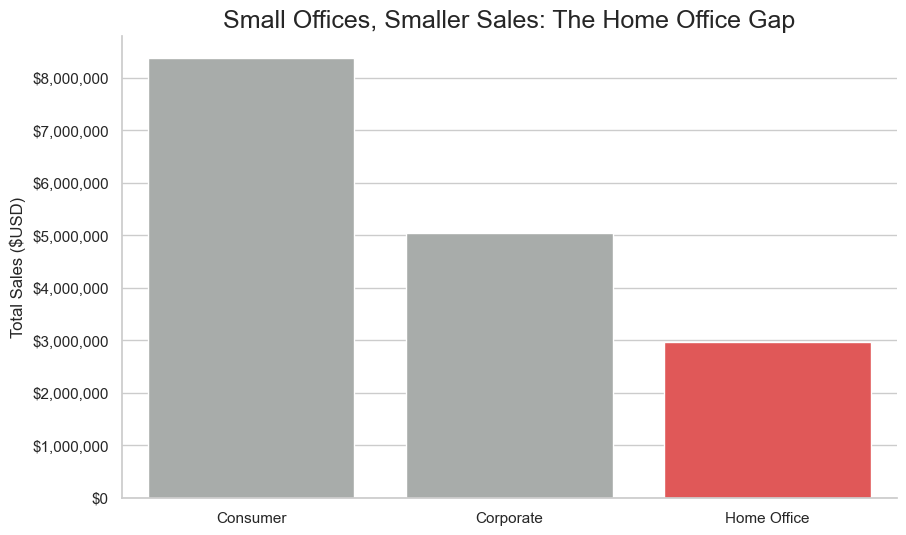

In [226]:
# example using result1
plt.figure(figsize=(10,6))
colors = ["#a7adaa", "#a7adaa", "#f74141" ]
sns.barplot(result1, x='customer_category', y='total_sales', palette=colors, hue='customer_category', legend=False)
plt.title('Small Offices, Smaller Sales: The Home Office Gap',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Sales ($USD)')

#for those wondering how to get rid of scientific notation! Set style to plain:
plt.ticklabel_format(style='plain', axis='y')

#mticker is a great library for helping tick mark formatting, such as adding commas and dollar signs in this case
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

#using the seaborn library, despining is way easier!
sns.despine()
plt.show()


1. Total Sales and Profit by Customer Category

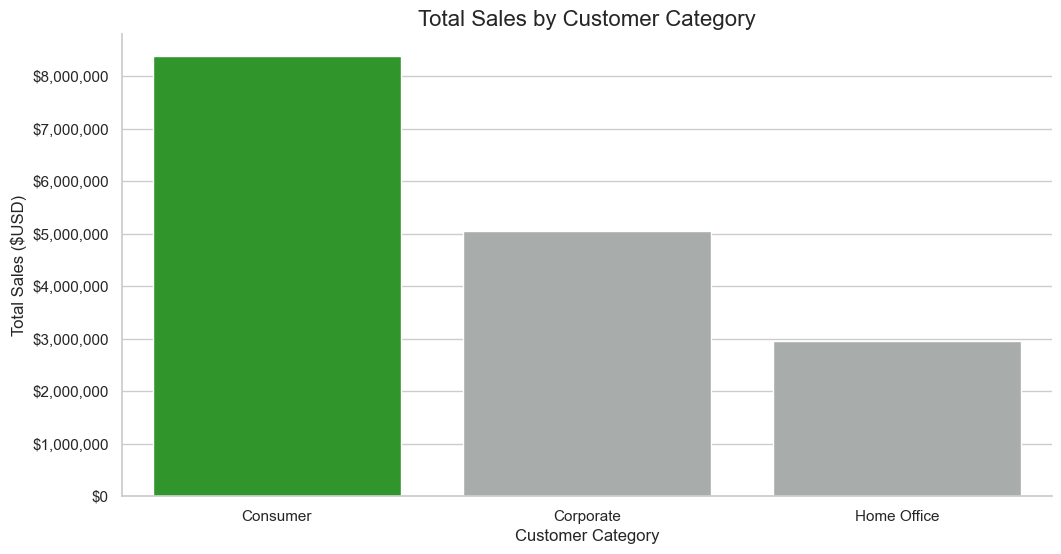

In [227]:
plt.figure(figsize=(12,6))
colors = ["#a7adaa", "#a7adaa", "#20A71B"]
sns.barplot(data=result1, x='customer_category', y='total_sales', hue='total_sales', palette=colors, legend=False)
plt.title('Total Sales by Customer Category', fontsize=16)
plt.ylabel('Total Sales ($USD)')
plt.xlabel('Customer Category')
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
sns.despine()
plt.show()

2. Top 10 Customers by Profit

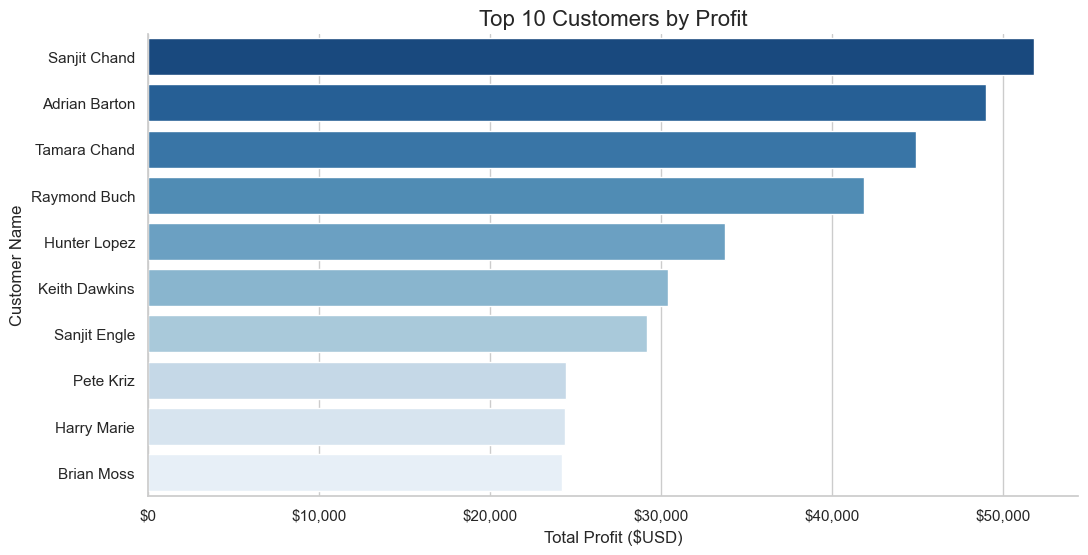

In [228]:
plt.figure(figsize=(12,6))
sns.barplot(data=result2, x='total_sales', y='customer_name', hue='customer_name', palette="Blues_r")
plt.title('Top 10 Customers by Profit', fontsize=16)
plt.xlabel('Total Profit ($USD)')
plt.ylabel('Customer Name')
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
sns.despine()
plt.show()

3. Profit by Product Category and Subcategory

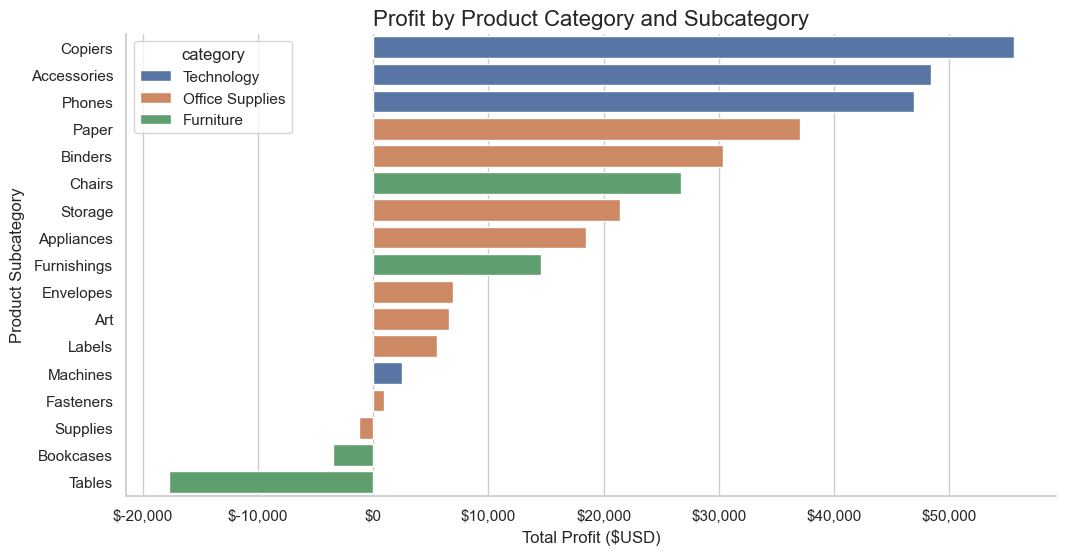

In [229]:
plt.figure(figsize=(12,6))
sns.barplot(data=result3, x='total_profit', y='subcategory', hue='category', dodge=False)
plt.title('Profit by Product Category and Subcategory', fontsize=16)
plt.xlabel('Total Profit ($USD)')
plt.ylabel('Product Subcategory')
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
sns.despine()
plt.show()


4. Total Sales by Month & Year (Highest Sales Month)

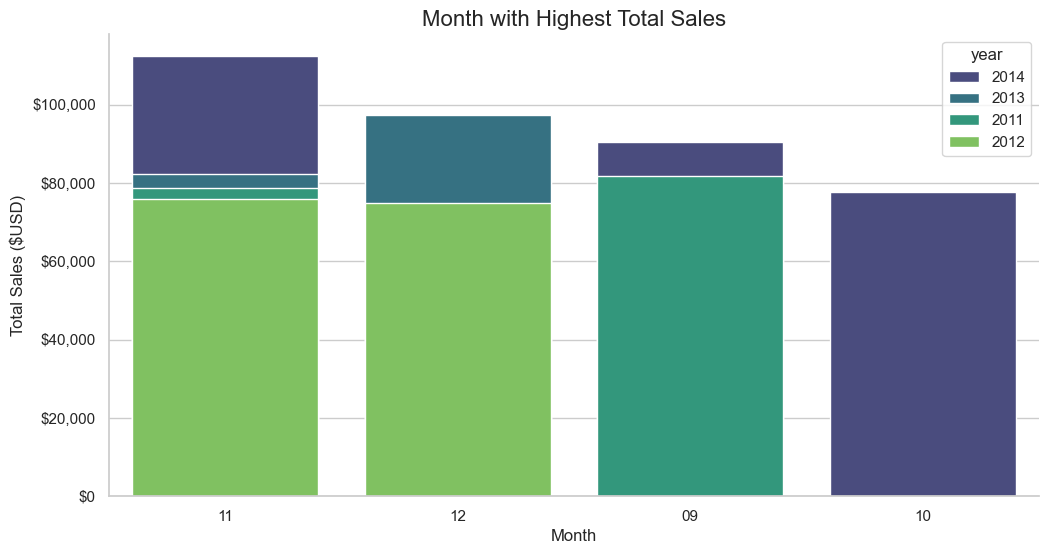

In [230]:
plt.figure(figsize=(12,6))
sns.barplot(data=result7, x='month', y='total_sales', hue='year', palette='viridis', dodge=False)
plt.title('Month with Highest Total Sales', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales ($USD)')
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
sns.despine()
plt.show()

Feedback for Module 3: <br>
Firstly, about class participation. Some people are vicarious learners and I feel like we have a number of them in our wednesday night cohort. <br>
Secondly, if I have no idea what I'm doing or no idea what is going on, I'm less likely to participate. I can guarantee some folks are out of their depths and struggling to keep up. I know I am! I feel bonkers haha.<br>
Lastly, some of these classwork workflows are really intense for needing to also be working on our capstone. Maybe incorporating some capstone progress updates into the weekly work like we did with the data cleaning exercises. 